<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/04_Transfer_Learning_Feature_Extraction_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Mar 21 02:08:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Transfer Learning with TensorFlow - Feature Extraction

### What is Transfer Learning
Surely someone has spend the time crafting the right model for your job...
- We can leverage an **existing neural network architecture** which is proven to work on problems similar to our own. 
- Can leverage a working network architecture which has **already learned  patterns similar data** to our own. (often results in great results with less data)

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

### Things will be doing in this lecture : 
- Introduce Transfer Learning with TensorFlow. 
- Using a small dataset to experiment faster (10% training examples). 
- Building a **transfer learning feature extraction** model with TensorFlow Hub.
- Use TensorBoard to track modelling experiments and results.

## Download and Becoming one with the Data

In [2]:
# Get data  (10% of 10 food classes From Food101)
import zipfile

# Download the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-03-21 02:08:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   149MB/s    in 1.1s    

2021-03-21 02:08:48 (149 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder? 
import os 

# Walkthrough 10 percent data directory and list number of files
for dirpath , dirnames , filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}"')

There are 2 directories and 0 images in "10_food_classes_10_percent"
There are 10 directories and 0 images in "10_food_classes_10_percent/test"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/sushi"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_wings"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/fried_rice"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/pizza"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/steak"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry"
There are 0 directories and 250 images in "10_food_classes_10_percent/test/grilled_salmon

Breaking down the train and test set, 
- `train_set` --> has 75 images in each class. 
- `test_set` --> has 200 images in each class.

## Create some dataloaders (preparing the data)

We'll use `ImageDataGenerator` class to load in our images in batches. 

In [4]:
# Setup data inputs 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up global variable (Variable in CAPS --> means some sort of hyperparameters)
IMG_SHAPE = (224 , 224)
BATCH_SIZE = 32

# Setting up the path to train and test
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

# Creating a instance of the ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale= 1/255.)

# Applying the generator to rescale our data
print(f'Training Images......')
train_data_10_percent = train_datagen.flow_from_directory(train_dir , 
                                                          target_size = IMG_SHAPE, 
                                                          batch_size = BATCH_SIZE , 
                                                          class_mode = 'categorical')

print('\nTesting Images.....')
test_data_10_percent = test_datagen.flow_from_directory(test_dir , 
                                                        target_size = IMG_SHAPE , 
                                                        batch_size = BATCH_SIZE , 
                                                        class_mode = 'categorical')

Training Images......
Found 750 images belonging to 10 classes.

Testing Images.....
Found 2500 images belonging to 10 classes.


## Setting up Callbacks (things to run whilst our model trains)

Callbacks are extra-functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are: 
- Tracking Experiments with `TensorBoard` callback. 
- Model checkpoint with `ModelCheckpoint` callback.
- Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping` callback. 

Create TensorBoard Callback, now we want to functionized because we need to create a new folder for each model.  

In [5]:
# Creating TensorBoard 
import datetime # timestamps for when our model has run

def create_tensorboard_callback(dir_name , experiment_name):

  # Creating the log directory to save the experiments
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y/%m/%d - %H:%M:%S")

  # Creating a tensorboard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving tensorboard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch. 

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

Often in Deeplearning, higher the number efficientnet(b0......b7) means the more complex the model. 

- Resnet : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4

 

In [6]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let create function create_model() to create a model from URL
def create_model(model_url , num_classes = 10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Args: 
     model_url (str): A TensorFlow Hub feature extraction URL 
     num_classes (int): Number of output neuron in the output layer, should be 
                       equal to the number of target classes, default 10. 

  Returns: 
  An uncompiled Keras Sequential model with model_url as feature extractor layer 
  and Dense output layer with num_classes output neurons. 
  '''
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url , 
                                           trainable = False, # freeze the already learnt model 
                                           name = 'feature_extraction_layer' , 
                                           input_shape = IMG_SHAPE + (3,)) # (224, 224, 3)

  # Create our own model 
  model = tf.keras.Sequential([
    feature_extraction_layer , 
    layers.Dense(num_classes , activation=tf.keras.activations.softmax , name = 'output_layer')
  ])
  
  return model

#### Creating ResNet TensorFlow Hub Extraction model

In [9]:
train_data_10_percent.num_classes

10

In [10]:
# Let's use that in resnet model 
resnet_model = create_model(model_url= resnet_url , 
                            num_classes = train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


- `feature_extraction_layer` --> Will be the Non-trainable parameters
- `output_layer (Dense)` --> only trainable parameters

In [12]:
# Compile the model 
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

In [13]:
# Fit the model 
history = resnet_model.fit(train_data_10_percent , 
                           steps_per_epoch = len(train_data_10_percent) , 
                           validation_data = test_data_10_percent , 
                           validation_steps = len(test_data_10_percent) , 
                           epochs = 5 , 
                           callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub' , 
                                                                    experiment_name = 'resnet50V2')])

Saving tensorboard log files to: tensorflow_hub/resnet50V2/2021/03/21 - 02:09:00
Epoch 1/5
24/24 [==============================] - 54s 807ms/step - loss: 2.2122 - accuracy: 0.2707 - val_loss: 1.1293 - val_accuracy: 0.6468
Epoch 2/5
24/24 [==============================] - 16s 671ms/step - loss: 0.9615 - accuracy: 0.7046 - val_loss: 0.8099 - val_accuracy: 0.7544
Epoch 3/5
24/24 [==============================] - 16s 678ms/step - loss: 0.6245 - accuracy: 0.8181 - val_loss: 0.7179 - val_accuracy: 0.7716
Epoch 4/5
24/24 [==============================] - 16s 673ms/step - loss: 0.4816 - accuracy: 0.8702 - val_loss: 0.6765 - val_accuracy: 0.7804
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.3694 - accuracy: 0.9142 - val_loss: 0.6623 - val_accuracy: 0.7832


Wow! 

Those were some amazing results compared to our CNN model in previous lecture. Our transfer learning extractor model outperformed all of the previous models we built by hand...(substantially) and in a quicker training time AND only the **10% of the training examples (75 images per training set)**

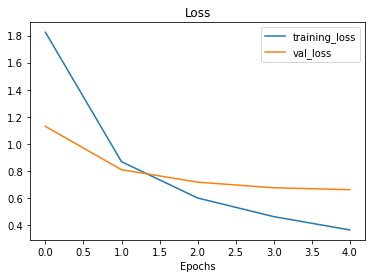

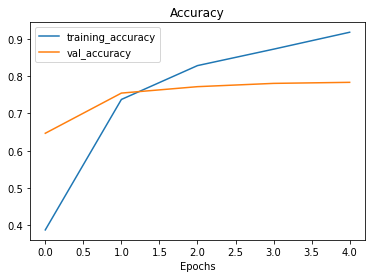

In [15]:
plot_loss_curves(history)

**Tidbit:** You could put a function like this into a script like `helper.py` and import it when needed.

In [25]:
# Plot the validation and training curves 
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  
  '''
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History Object 

  Returns:
    Plots of training/validation loss and accuracy metrics
  
  This function will fail if we use any other evaluation metrics than accuracy
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss 
  plt.plot(epochs , loss , label ='training_loss')
  plt.plot(epochs , val_loss , label ='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy 
  plt.figure()
  plt.plot(epochs , accuracy , label = 'training_accuracy')
  plt.plot(epochs , val_accuracy , label ='validation_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()



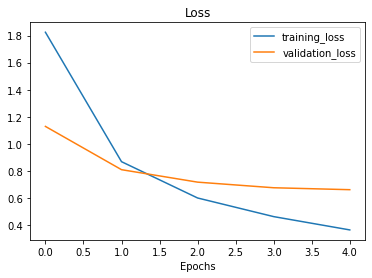

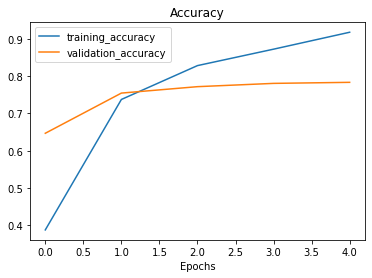

In [26]:
# Using the function to check our ResNet history 
plot_loss_curves(history)

## Creating and testing EfficientNet B0 TensorFlow Extraction Model

In [32]:
# Creating a extraction model with efficientnet
efficient_net_model = create_model(model_url = efficientnet_url , 
                                   num_classes = train_data_10_percent.num_classes)

# Checking the summary of the model 
efficient_net_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [33]:
# Compile the model 
efficient_net_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                            optimizer = tf.keras.optimizers.Adam() , 
                            metrics = ['accuracy'])

In [29]:
# Fitting the model here for 5 epochs 
history_efficient_net = efficient_net_model.fit(train_data_10_percent , 
                                                epochs = 5 ,
                                                steps_per_epoch = len(train_data_10_percent) , 
                                                validation_data = test_data_10_percent , 
                                                validation_steps = len(test_data_10_percent) , 
                                                callbacks = [create_tensorboard_callback(dir_name ='tensorflow_hub/' , 
                                                                                         experiment_name = 'efficientnet_b0')])

Saving tensorboard log files to: tensorflow_hub//efficientnet_b0/2021/03/21 - 02:57:19
Epoch 1/5
24/24 [==============================] - 25s 785ms/step - loss: 2.0443 - accuracy: 0.3389 - val_loss: 1.2536 - val_accuracy: 0.7440
Epoch 2/5
24/24 [==============================] - 15s 639ms/step - loss: 1.1091 - accuracy: 0.7763 - val_loss: 0.8393 - val_accuracy: 0.8288
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 0.7729 - accuracy: 0.8198 - val_loss: 0.6789 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 15s 642ms/step - loss: 0.6164 - accuracy: 0.8756 - val_loss: 0.5966 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 15s 636ms/step - loss: 0.5045 - accuracy: 0.9018 - val_loss: 0.5459 - val_accuracy: 0.8608


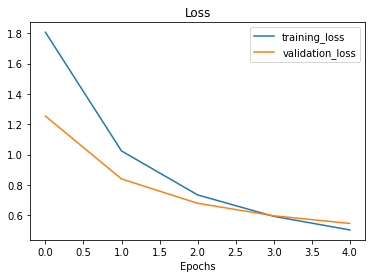

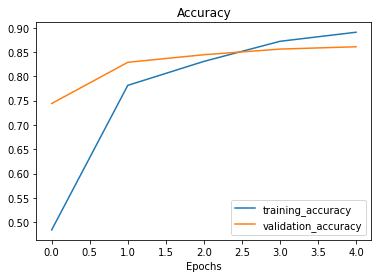

In [30]:
# Plotting the loss curves 
plot_loss_curves(history_efficient_net)

That's impressive! 😮 . It seems EfficientNet pre-trained model performs really well than our resnet model before. For instance,
- `Resnet`: **val_accuracy:** 78% / **loss:** 0.6623
- `Efficient_net` : **val_accuracy:** 86% / **loss:** 0.5459

In [34]:
# Let's train for another 5 epochs 
history_efficient_net = efficient_net_model.fit(train_data_10_percent , 
                                                epochs = 10 ,
                                                steps_per_epoch = len(train_data_10_percent) , 
                                                validation_data = test_data_10_percent , 
                                                validation_steps = len(test_data_10_percent) , 
                                                callbacks = [create_tensorboard_callback(dir_name ='tensorflow_hub/' , 
                                                                                         experiment_name = 'efficientnet_b0_10_epochs')])

Saving tensorboard log files to: tensorflow_hub//efficientnet_b0_10_epochs/2021/03/21 - 03:07:15
Epoch 1/10
24/24 [==============================] - 24s 753ms/step - loss: 2.0826 - accuracy: 0.2900 - val_loss: 1.2840 - val_accuracy: 0.7340
Epoch 2/10
24/24 [==============================] - 15s 641ms/step - loss: 1.1270 - accuracy: 0.7782 - val_loss: 0.8666 - val_accuracy: 0.8240
Epoch 3/10
24/24 [==============================] - 15s 642ms/step - loss: 0.7922 - accuracy: 0.8315 - val_loss: 0.6994 - val_accuracy: 0.8428
Epoch 4/10
24/24 [==============================] - 15s 648ms/step - loss: 0.6483 - accuracy: 0.8493 - val_loss: 0.6141 - val_accuracy: 0.8580
Epoch 5/10
24/24 [==============================] - 15s 641ms/step - loss: 0.5113 - accuracy: 0.9084 - val_loss: 0.5619 - val_accuracy: 0.8620
Epoch 6/10
24/24 [==============================] - 15s 640ms/step - loss: 0.4475 - accuracy: 0.9070 - val_loss: 0.5236 - val_accuracy: 0.8676
Epoch 7/10
24/24 [===========================

In [40]:
# How many layers does our efficientnetbo has? 
print(efficient_net_model.layers)
print(f'Number of layers in the efficient net model: {len(efficient_net_model.layers[0].weights)}')

[<tensorflow_hub.keras_layer.KerasLayer object at 0x7efbe692e150>, <tensorflow.python.keras.layers.core.Dense object at 0x7efbe21a02d0>]
Number of layers in the efficient net model: 309


In [42]:
# Checking the patterns / weights
efficient_net_model.layers[0].weights # Patterns from the pre-trained model learned on the ImageNet

[<tf.Variable 'stem_conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-02, -8.79267603e-02,
       

## Different Types of Transfer Learning 

* 'As is' transfer learning using an existing model with no changes whatsoever (e.g Using a ImageNet model on 1000 ImageNet classes, none of our own).
- **Feature Extraction** transfer learning - use the pre-learned patterns of an existing modle(e.g efficientnet_b0 trained on ImageNet and adjust the output layer for your own layer).
- **Fine Tuning:** tranfer learning - use the pre-learned patterns of an existing model and "fine tune" many or all of the underlying layers (including new output layers). 

## Comparing our models result with TensorBoard! 🎛

> 🔑 **Dan Note:** When you upload things to TensorBoard.dev your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNet_b0 vs. Resnet50_v2'\
  --description 'Comparing two different TF Hub Feature Extraction model architecture using 10% of the training data' \
  --one_shot


#### Our TensorBoard experiments are uploaded publicaly here https://tensorboard.dev/experiment/c20GYNiYQVeXd8vmYMBT4g/

In [44]:
# Check out what experiments you have
!tensorboard dev list

2021-03-21 04:03:02.736722: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/c20GYNiYQVeXd8vmYMBT4g/
	Name                 EfficientNet_b0 vs. Resnet50_v2
	Description          Comparing two different TF Hub Feature Extraction model architecture using 10% of the training data
	Id                   c20GYNiYQVeXd8vmYMBT4g
	Created              2021-03-21 03:49:12 (13 minutes ago)
	Updated              2021-03-21 03:49:17 (13 minutes ago)
	Runs                 8
	Tags                 3
	Scalars              88
	Tensor bytes         0
	Binary object bytes  14282177
Total: 1 experiment(s)


In [45]:
# Delete an experiment 
# !tensorboard dev delete --experiment_id c20GYNiYQVeXd8vmYMBT4g